# DAOS Filesystem with Tensorflow (Using MNIST)

## Overview

This tutorial shows how to use read and write files on [DAOS Filesystem](https://docs.daos.io/) with TensorFlow, through TensorFlow IO's DAOS file system integration.

A machine running DAOS natively or through a [docker emulator](https://github.com/daos-stack/daos/tree/master/utils/docker) is needed to run this tutorial and/or use the Tensorflow IO DAOS integration. The DAOS Pool and Container used for this tutorial will be created and deleted within this tutorial, where we will be training and testing a simple Neural Network on the MNIST Dataset loaded from the DAOS File System Plugin.

The pool and container id or label are part of the filename uri:
```
dfs://<pool_id>/<cont_id>/<path>
dfs://<pool-label>/cont-label/<path>
```

## Setup and usage

### Install required packages, and restart runtime

In [1]:
try:
  %tensorflow_version 2.x 
except Exception:
  pass

!pip install tensorflow-io

### Create Pool and Container

In [2]:
!dmg -i pool create -s 500M TEST_POOL
!daos cont create --pool=TEST_POOL --type=POSIX TEST_CONT

Creating DAOS pool with manual per-server storage allocation: 500 MB SCM, 0 B NVMe (100.00% ratio)
Pool created with 100.00%,0.00% storage tier ratio
--------------------------------------------------
  UUID                 : 852b1460-ed1e-4d08-a887-c48035656d16
  Service Ranks        : 0                                   
  Storage Ranks        : 0                                   
  Total Size           : 500 MB                              
  Storage tier 0 (SCM) : 500 MB (500 MB / rank)              
  Storage tier 1 (NVMe): 0 B (0 B / rank)                    

  Container UUID : abf21b6c-021c-462a-89fd-e18d229ac239
  Container Type : POSIX                               

Successfully created container abf21b6c-021c-462a-89fd-e18d229ac239


Importing the needed libraries

In [3]:
import tensorflow as tf
import tensorflow_io as tfio

Initializing our dfs path

In [4]:
dfs_url = "dfs://TEST_POOL/TEST_CONT/" # This the path we'll be using to load and access the dataset
pwd = !pwd
posix_url = pwd[0] + "/tests/test_dfs/"

Install Datasets

In [5]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -O $(pwd)/tests/test_dfs/train.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -O $(pwd)/tests/test_dfs/train_labels.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -O $(pwd)/tests/test_dfs/test.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -O $(pwd)/tests/test_dfs/test_labels.gz

--2021-12-15 15:47:21--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘/home/daos/daos/bs-daos-tensorflow-io/tests/test_dfs/train.gz’

/home/daos/daos/bs- 100%[===================>]   9.45M  1.89MB/s    in 4.3s    

2021-12-15 15:47:25 (2.22 MB/s) - ‘/home/daos/daos/bs-daos-tensorflow-io/tests/test_dfs/train.gz’ saved [9912422/9912422]

--2021-12-15 15:47:25--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving 

Copying the Data from the POSIX Filesystem to the DAOS Filesystem under the pool and container we just created

In [6]:
file_names = ["train.gz", "test.gz", "train_labels.gz", "test_labels.gz"]
for file in file_names:
  tf.io.gfile.copy(posix_url + file, dfs_url + file, True)
    


Checking Our Training Images and Training Labels Exist under the specified pool and container

In [7]:
images = dfs_url + "train.gz"
labels = dfs_url + "train_labels.gz"
if tf.io.gfile.exists(images) and tf.io.gfile.exists(labels):
  print("True")
else:
  print("False")

True


Loading MNIST Data from the DFS using tensorflow-io's built in MNIST loading functionality

In [8]:

d_train = tfio.IODataset.from_mnist(
    images,
    labels
)

Pre-processing and Building a simple Keras Model

In [9]:
# Shuffle the elements of the dataset.
d_train = d_train.shuffle(buffer_size=1024)

# By default image data is uint8, so convert to float32 using map().
d_train = d_train.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y))

# prepare batches the data just like any other tf.data.Dataset
d_train = d_train.batch(32)

# Build the model.
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

Compiling the model we just built

In [10]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

And finally, training on the dataset for 5 epochs

In [11]:
history = model.fit(d_train, epochs=15, steps_per_epoch=100)

Epoch 1/15
100/100 [==============================] - 1s 2ms/step - loss: 0.6673 - accuracy: 0.8100
Epoch 2/15
100/100 [==============================] - 0s 3ms/step - loss: 0.3216 - accuracy: 0.9081
Epoch 3/15
100/100 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.9053
Epoch 4/15
100/100 [==============================] - 0s 3ms/step - loss: 0.2695 - accuracy: 0.9228
Epoch 5/15
100/100 [==============================] - 0s 2ms/step - loss: 0.2555 - accuracy: 0.9259
Epoch 6/15
100/100 [==============================] - 0s 2ms/step - loss: 0.1988 - accuracy: 0.9397
Epoch 7/15
100/100 [==============================] - 0s 2ms/step - loss: 0.2119 - accuracy: 0.9388
Epoch 8/15
100/100 [==============================] - 0s 2ms/step - loss: 0.1740 - accuracy: 0.9472
Epoch 9/15
100/100 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9444
Epoch 10/15
100/100 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.9400

Plot of Loss vs Epoch during Training

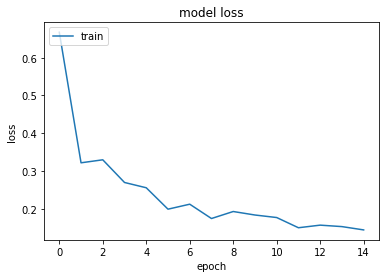

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Check Test Data is available

In [13]:
test_images = dfs_url + "test.gz"
test_labels = dfs_url + "test_labels.gz"
if tf.io.gfile.exists(test_images) and tf.io.gfile.exists(test_labels):
  print("True")
else:
  print("False")

True


Apply same pre-processing and batching on test data

In [14]:
d_test = tfio.IODataset.from_mnist(
    test_images,
    test_labels,
)

# Shuffle the elements of the dataset.
d_test = d_test.shuffle(buffer_size=1024)

# By default image data is uint8, so convert to float32 using map().
d_test = d_test.map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y))

# prepare batches the data just like any other tf.data.Dataset
d_test = d_test.batch(32)

Evaluate our model on both test and train data

In [15]:
_, train_acc = model.evaluate(d_train, verbose=0)
_, test_acc = model.evaluate(d_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.966, Test: 0.961


Prediction Example

Predicted Value is 7


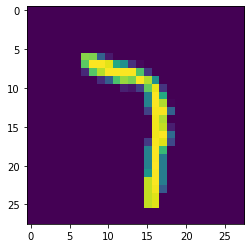

In [16]:
import numpy as np
iterator = iter(d_test)
elem = iterator.get_next()[0][0]
plt.imshow(elem)
prediction = model.predict(np.array([elem]))
result = np.where(prediction[0] == np.amax(prediction[0]))
print("Predicted Value is" ,result[0][0])

### Cleanup

In [17]:
!dmg -i pool destroy -f TEST_POOL

Pool-destroy command succeeded
